In [2]:
import spacy
import pandas as pd
import jsonlines
import numpy as np
spacy.require_gpu()

True

In [3]:
nlp = spacy.load("./incarceration_model_binary_trf_v2/model-best/", exclude="tagger,parser,attribute_ruler,lemmatizer,ner")
                                                                             
# nlp = spacy.load('/home/vs428/Documents/Moore/followup_model_v3/model-best', exclude="tagger,parser,attribute_ruler,lemmatizer,ner")
#nlp_orig = spacy.load("en_core_web_trf")
#nlp.add_pipe("parser", source=nlp_orig, after="transformer")
#nlp.add_pipe("tagger", source=nlp_orig, after="parser")
#nlp.add_pipe("attribute_ruler", source=nlp_orig, after="tagger")
#nlp.add_pipe("lemmatizer", source=nlp_orig, after="attribute_ruler")
#nlp.add_pipe("ner", source=nlp_orig, after="lemmatizer")

In [4]:
anns = []
with jsonlines.open("/home/vs428/project/Incarceration_Data/incarceration_status_v2_v2_binary.jsonl") as reader:
    for line in reader:
        anns.append(line)

In [5]:
texts = [ann['text'] for ann in anns]

In [6]:
from spacy.tokens import DocBin
doc_bin = DocBin().from_disk("/home/vs428/Documents/Incarceration/incarceration_status_binary_v2/dev.spacy")


In [7]:
dev_docs = list(doc_bin.get_docs(nlp.vocab))

In [8]:
dev_doc_texts = [doc.text for doc in dev_docs]

In [9]:
# taken from https://stackoverflow.com/a/44764557/1726404
'''
This works by using nlp.pipe and putting our records into tuples. We process it as tuples and get the context
In our work, the context is just the study id. 
We get the entity text, label, start and stop characters for each entity
we convert that to a json string, we then put the [context,json] together into a list
append this list to nlp_out
then turn nlp out into a df with 1 col being study id and the other being the nlp out
Finally we merge the df with our main data df. Now we have a column with the text
'''
import json
nlp_out = []
docs = []
count = 0
for doc in nlp.pipe(dev_doc_texts, batch_size=100, n_process=1):
    docs.append(doc)
    out_ = doc.cats
    nlp_out.append([count, json.dumps(out_, indent = 2)])
    if count % 50 == 0:
        print(count)
    count +=1
nlp_df = pd.DataFrame(nlp_out, columns=['study_id', 'NLP_OUT'])

0
50


Token indices sequence length is longer than the specified maximum sequence length for this model (878 > 512). Running this sequence through the model will result in indexing errors


100


In [10]:
# len(dev_docs)

In [11]:
nlp_df['y_true'] = [dev_doc.cats for dev_doc in dev_docs]

In [12]:
nlp_df['y_true'] = nlp_df['y_true'].astype(str)

In [13]:
import ast
def convert_dict_str_to_dict(x, col_name):
    tmp = ast.literal_eval(x[col_name])
    return tmp

In [14]:
score_df = nlp_df.apply(convert_dict_str_to_dict, axis=1, col_name="NLP_OUT", result_type="expand")


In [15]:
score_df = score_df.rename({"Prior_History_Incarceration":"y_pred_score"}, axis=1)

In [16]:
score_df2 = nlp_df.apply(convert_dict_str_to_dict, axis=1, col_name="y_true", result_type="expand")
score_df2 = score_df2.rename({"Prior_History_Incarceration":"y_true_score"}, axis=1)

In [17]:
conf_mat_df = pd.concat([score_df, score_df2], axis=1)

In [18]:
conf_mat_df['y_pred'] = np.where(conf_mat_df['y_pred_score'] > 0.5, True, False)

In [19]:
conf_mat_df['y_true'] = np.where(conf_mat_df['y_true_score'] > 0.5, True, False)

In [20]:
from sklearn.metrics import ConfusionMatrixDisplay

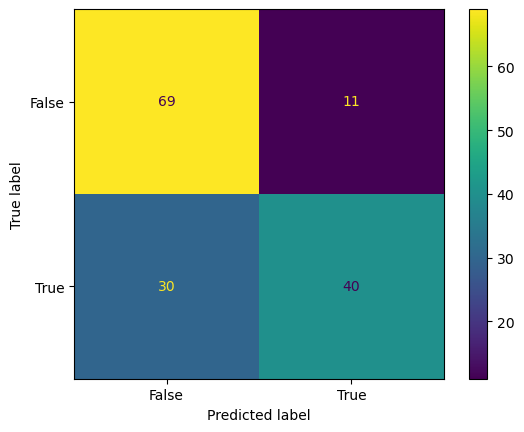

In [21]:
ConfusionMatrixDisplay.from_predictions(conf_mat_df['y_true'], conf_mat_df['y_pred'], )


In [283]:
from sklearn.metrics import classification_report

In [286]:
pd.DataFrame(classification_report(conf_mat_df['y_true'], conf_mat_df['y_pred'], output_dict=True))

,False,True,accuracy,macro avg,weighted avg
precision,0.69697,0.784314,0.726667,0.740642,0.737730
recall,0.86250,0.571429,0.726667,0.716964,0.726667
f1-score,0.77095,0.661157,0.726667,0.716053,0.719713
support,80.00000,70.000000,0.726667,150.000000,150.000000


In [22]:
conf_mat_df['text'] = dev_doc_texts

In [23]:
nlp_df = pd.concat([nlp_df, score_df], axis=1)

In [29]:
conf_mat_df

,y_pred_score,y_true_score,y_pred,y_true,text
0,0.812052,1.0,True,True,Yale New Haven Hospital-Ysc YALE NEW HAVEN HO...
1,0.000585,0.0,False,False,YaleNewHavenHealth\nEmergency Department Visit...
2,0.193504,0.0,False,False,Emergency Medicine Resident MDM\n-------------...
3,0.883572,1.0,True,True,History\nChief Complaint \nPatient presents wi...
4,0.411855,0.0,False,False,11:37 AM pt presents to the ED with assistance...
...,...,...,...,...,...
145,0.539937,0.0,True,False,8:05 PM Pt presents to the ED for evaluation o...
146,0.514983,1.0,True,True,"6:25 PM The pt is a 27 yo MAAF w/hx of OUD, CU..."
147,0.879773,1.0,True,True,History\nChief Complaint \nPatient presents wi...
148,0.188357,0.0,False,False,Adult Psychiatric Evaluation Emergency Depart...


In [30]:
# nlp_df['Prior_History_Incarceration_rec'] = np.where(nlp_df['Prior_History_Incarceration'].values > 0.5, True, False)


In [34]:
conf_mat_df['y_pred'].value_counts()

False    99
True     51
Name: y_pred, dtype: int64

# Use SHAP

In [85]:
fp = conf_mat_df[(conf_mat_df['y_pred'] == True) & (conf_mat_df['y_true'] == False)]
fn = conf_mat_df[(conf_mat_df['y_pred'] == False) & (conf_mat_df['y_true'] == True)]

In [36]:
import shap

In [37]:
nlp.analyze_pipes()

{'summary': {'transformer': {'assigns': ['doc._.trf_data'],
   'requires': [],
   'scores': [],
   'retokenizes': False},
  'textcat_multilabel': {'assigns': ['doc.cats'],
   'requires': [],
   'scores': ['cats_score',
    'cats_score_desc',
    'cats_micro_p',
    'cats_micro_r',
    'cats_micro_f',
    'cats_macro_p',
    'cats_macro_r',
    'cats_macro_f',
    'cats_macro_auc',
    'cats_f_per_type',
    'cats_macro_auc_per_type'],
   'retokenizes': False}},
 'problems': {'transformer': [], 'textcat_multilabel': []},
 'attrs': {'doc._.trf_data': {'assigns': ['transformer'], 'requires': []},
  'doc.cats': {'assigns': ['textcat_multilabel'], 'requires': []}}}

In [41]:
docs[0].cats

{'Prior_History_Incarceration': 0.8120521306991577}

In [48]:
classes = list(nlp.get_pipe("textcat_multilabel").labels)


In [49]:
[doc.cats[cat] for cat in classes] + [1-doc.cats[cat] for cat in classes]

[0.7777819633483887, 0.22221803665161133]

In [50]:
tokenizer_spacy = spacy.tokenizer.Tokenizer(nlp.vocab)
classes = list(nlp.get_pipe("textcat_multilabel").labels)
# Define a function to predict
def predict(texts):
    # convert texts to bare strings
    texts = [str(text) for text in texts]
    results = []
    for doc in nlp.pipe(texts):
        # results.append([{'label': cat, 'score': doc.cats[cat]} for cat in doc.cats])
        result = [doc.cats[cat] for cat in classes] + [1-doc.cats[cat] for cat in classes]        
        results.append(result)
    return results

# Create a function to create a transformers-like tokenizer to match shap's expectations
def tok_wrapper(text, return_offsets_mapping=False):
    doc = tokenizer_spacy(text)
    out = {"input_ids": [tok.norm for tok in doc]}
    if return_offsets_mapping:
        out["offset_mapping"] = [(tok.idx, tok.idx + len(tok)) for tok in doc]
    return out

In [51]:
import shap
# Create the Shap Explainer
# - predict is the "model" function, adapted to a transformers-like model
# - masker is the masker used by shap, which relies on a transformers-like tokenizer
# - algorithm is set to permutation, which is the one used for transformers models
# - output_names are the classes (although it is not propagated to the permutation explainer currently, which is why plots do not have the labels)
# - max_evals is set to a high number to reduce the probability of cases where the explainer fails because there are too many tokens
explainer = shap.Explainer(
    predict,
    masker=shap.maskers.Text(tok_wrapper),
    algorithm="permutation",
    output_names=classes,
    max_evals=5400,
)

In [52]:
misclassified['text'].sample(3)

145    8:05 PM Pt presents to the ED for evaluation o...
129    History\nChief Complaint \nPatient presents wi...
59     Adult Psychiatric Evaluation  \n\t\t\t\t\t6/17...
Name: text, dtype: object

In [ ]:
shapleys1 = fp['text'].sample(8)

In [ ]:
shap_values = explainer(shapleys1.tolist())

In [ ]:
shap_values.output_names = classes + ['No_Hx_Incarceration']

In [ ]:
output = shap.plots.text(shap_values, display=False)


In [ ]:
file ='false_positive_misclassified.html'
with open(file, "w") as f:
    f.write(output)

In [289]:
shapleys2 = fn['text'].sample(8)

In [ ]:
shap_values = explainer(shapleys2.tolist())

Permutation explainer:  62%|██████▎   | 5/8 [04:29<03:06, 62.23s/it]

In [ ]:
shap_values.output_names = classes + ['No_Hx_Incarceration']

In [ ]:
output = shap.plots.text(shap_values, display=False)


In [ ]:
file ='false_negative_misclassified.html'
with open(file, "w") as f:
    f.write(output)

# Dig into model performance

In [268]:
import matplotlib.pyplot as plt

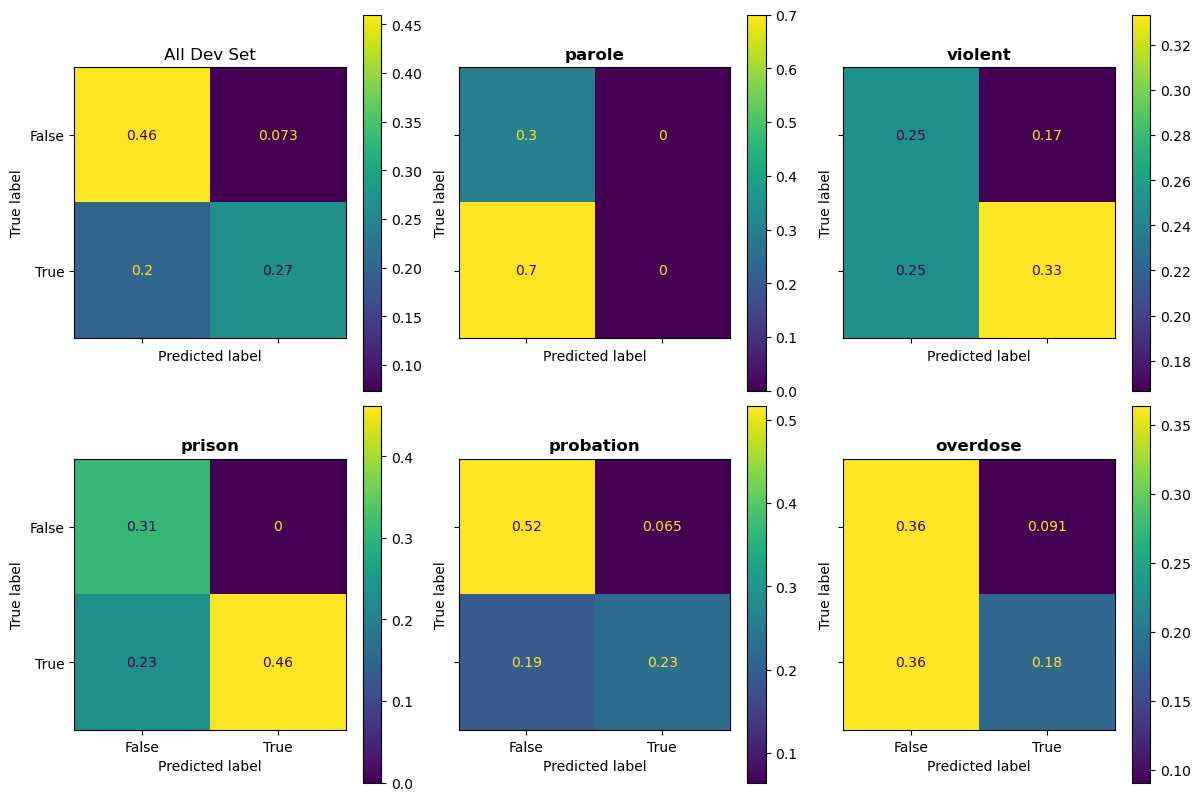

In [282]:
fig, axs = plt.subplots(2,3, 
                        figsize=(12,8),
                       sharex="all", sharey="all")

ConfusionMatrixDisplay.from_predictions(conf_mat_df['y_true'],
                                        conf_mat_df['y_pred'],
                                        normalize="all",
                                       ax=axs[0][0])
axs[0][0].set_title("All Dev Set")

subset1 = conf_mat_df[conf_mat_df['text'].str.contains("parole", flags=re.IGNORECASE)]
ConfusionMatrixDisplay.from_predictions(subset1['y_true'], 
                                        subset1['y_pred'], 
                                        normalize="all",
                                        ax=axs[0][1])
axs[0][1].set_title("parole", weight="bold")

subset2 = conf_mat_df[conf_mat_df['text'].str.contains("violent", flags=re.IGNORECASE)]
ConfusionMatrixDisplay.from_predictions(subset2['y_true'], 
                                        subset2['y_pred'], 
                                        normalize="all",
                                        ax=axs[0][2])
axs[0][2].set_title("violent", weight="bold")

subset3 = conf_mat_df[conf_mat_df['text'].str.contains("prison", flags=re.IGNORECASE)]
ConfusionMatrixDisplay.from_predictions(subset3['y_true'], 
                                        subset3['y_pred'], 
                                        normalize="all",
                                        ax=axs[1][0])
axs[1][0].set_title("prison", weight="bold")

subset4 = conf_mat_df[conf_mat_df['text'].str.contains(r"probation", flags=re.IGNORECASE)]
ConfusionMatrixDisplay.from_predictions(subset4['y_true'], 
                                        subset4['y_pred'], 
                                        normalize="all",
                                        ax=axs[1][1])
axs[1][1].set_title("probation", weight="bold")

subset4 = conf_mat_df[conf_mat_df['text'].str.contains(r"overdose", flags=re.IGNORECASE)]
ConfusionMatrixDisplay.from_predictions(subset4['y_true'], 
                                        subset4['y_pred'], 
                                        normalize="all",
                                        ax=axs[1][2])
axs[1][2].set_title("overdose", weight="bold")

fig.tight_layout(pad=0.5)

plt.savefig("X.png")